This notebook may be used as a start for your exploration of time series analysis using multi-layer neural network, which weights are selected with NSGA-II algorithm with respect to two opposite criteria (objectives) of PICP and PINRW.

X.csv and F.csv in this folder contain the computed solution vectors as well as objectives values, where 1-PICP is the first column, PINRW is the second column.

The authors are:

Chervyakov A. - problem statement and analysis, methodology. <br>
Nikulchev E. - results validation and criticism. <br>
Gusev A. - data analysis, pipeline construction, code writing, tuning and testing. <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


/tmp/ipykernel_610501/2285543036.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-27 11:27:17.224836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 11:27:17.225045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 11:27:17.635123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable

In [2]:
!pip show pymoo || pip install pymoo
from pymoo.core.problem import ElementwiseProblem


Name: pymoo
Version: 0.6.1.1
Summary: Multi-Objective Optimization in Python
Home-page: https://pymoo.org
Author: Julian Blank
Author-email: blankjul@msu.edu
License: Apache License 2.0
Location: /home/alexander/mambaforge/lib/python3.10/site-packages
Requires: Deprecated, autograd, scipy, matplotlib, cma, alive-progress, dill, numpy
Required-by: 


In [41]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize


In [3]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [4]:
#load the data

data = pd.read_csv('HistoricalData_1708930288397.csv',
                   header=0,
                   usecols=['Date', 'Close/Last'],
                   parse_dates=['Date'],
                   date_format='%m/%d/%Y')

df = data[['Date', 'Close/Last']].copy()


In [5]:
df = df.sort_values('Date')
df = df.reset_index(drop=True)



In [6]:
df.head()

,Date,Close/Last
0,2014-02-26,1845.16
1,2014-02-27,1854.29
2,2014-02-28,1859.45
3,2014-03-03,1845.73
4,2014-03-04,1873.91


In [7]:
df.tail()

,Date,Close/Last
2526,2024-02-16,5005.57
2527,2024-02-20,4975.51
2528,2024-02-21,4981.80
2529,2024-02-22,5087.03
2530,2024-02-23,5088.80


In [8]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [9]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


In [10]:
df.tail()

,Date,Close/Last
2526,2024-02-16,5005.57
2527,2024-02-20,4975.51
2528,2024-02-21,4981.80
2529,2024-02-22,5087.03
2530,2024-02-23,5088.80


In [11]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [12]:
df[:train_size].tail()

,Date,Close/Last
2019,2022-02-09,4587.18
2020,2022-02-10,4504.08
2021,2022-02-11,4418.64
2022,2022-02-14,4401.67
2023,2022-02-15,4471.07


In [13]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Close/Last'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Close/Last'].values.reshape(-1, 1))

def prepare_data(data, dates, n_steps):
    X, y, dates_output = [], [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix >= len(data):
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        dates_output.append(dates[end_ix])  # Используем переданные данные из столбца "Date"
    return np.array(X), np.array(y), np.array(dates_output)


# Определение параметров модели
n_steps = 3  # Длина временного окна
n_features = 1  # Количество признаков во временном окне

# Подготовка данных
X_train, y_train, _ = prepare_data(train_scaled, train['Date'], n_steps)
X_test, y_test, test_dates = prepare_data(test_scaled[:-6], test['Date'].values, n_steps)

# Преобразование в трехмерный массив (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [14]:
X_train.shape

(2021, 3, 1)

In [15]:
y_train.shape

(2021, 1)

In [16]:
X_test.shape

(498, 3, 1)

In [17]:
y_test.shape

(498, 1)

In [18]:
# Define the model
model = Sequential([
    LSTM(10, activation='relu'),
    Dense(units=2)
])

# Build the model
input_shape = input_shape=(n_steps, n_features)
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

2024-02-27 11:27:59.903842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 11:28:02.148471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 11:28:02.149038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
shape = get_shape(model)
print(shape)

[(1, 40), (10, 40), (40,), (10, 2), (2,)]


In [20]:
model.count_params()

502

In [21]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=model.count_params(),
                         n_obj=2,
                         xl=np.full(model.count_params(), -1),
                         xu=np.full(model.count_params(), 1)
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        global model, shape, X_train, y_train
        model.set_weights(set_shape(x,shape))
        predictions = model.predict(X_train)
        f1 = 1 - PICP(y_train, predictions)
        f2 = PINRW(predictions)

        out["F"] = [f1, f2]

problem = MyProblem()


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
algorithm = NSGA2(
    pop_size=model.count_params() + 2,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)





termination = get_termination("n_gen", 500)


res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

In [28]:
X_df = pd.DataFrame(X)

In [29]:
F_df = pd.DataFrame(F)

In [57]:
import datetime

# Получаем текущую дату и время
current_datetime = datetime.datetime.now()
# Преобразуем текущую дату и время в строку
current_datetime_str = current_datetime.strftime("%Y-%m-%d %H:%M:%S")

In [61]:
X_df.to_csv(f'LSTM_X_S&P_{current_datetime_str}.csv')

F_df.to_csv(f'LSTM_F_S&P_{current_datetime_str}.csv')

In [60]:
F_df = pd.read_csv('LSTM_F_S&P.csv')
F = np.array(F_df.iloc[:,1:])
X_df = pd.read_csv('LSTM_X_S&P.csv')
X = np.array(X_df.iloc[:,1:])

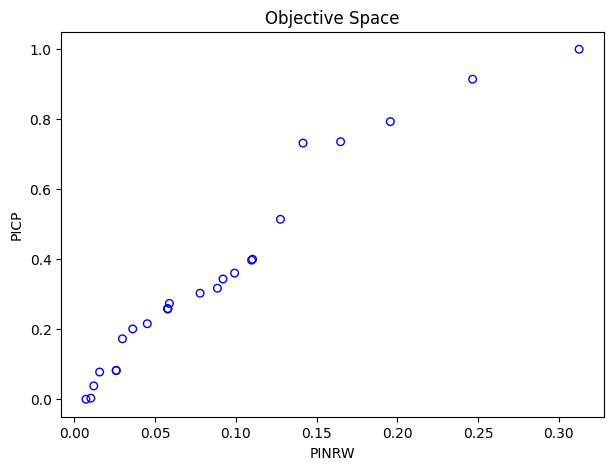

In [62]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], 1 - F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel('PINRW')
plt.ylabel('PICP')
plt.show()

In [32]:
y_test_unscaled = scaler.inverse_transform(y_test)

In [33]:
y_test.shape

(498, 1)

<H1> Predictions section:

/tmp/ipykernel_610501/2836881319.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


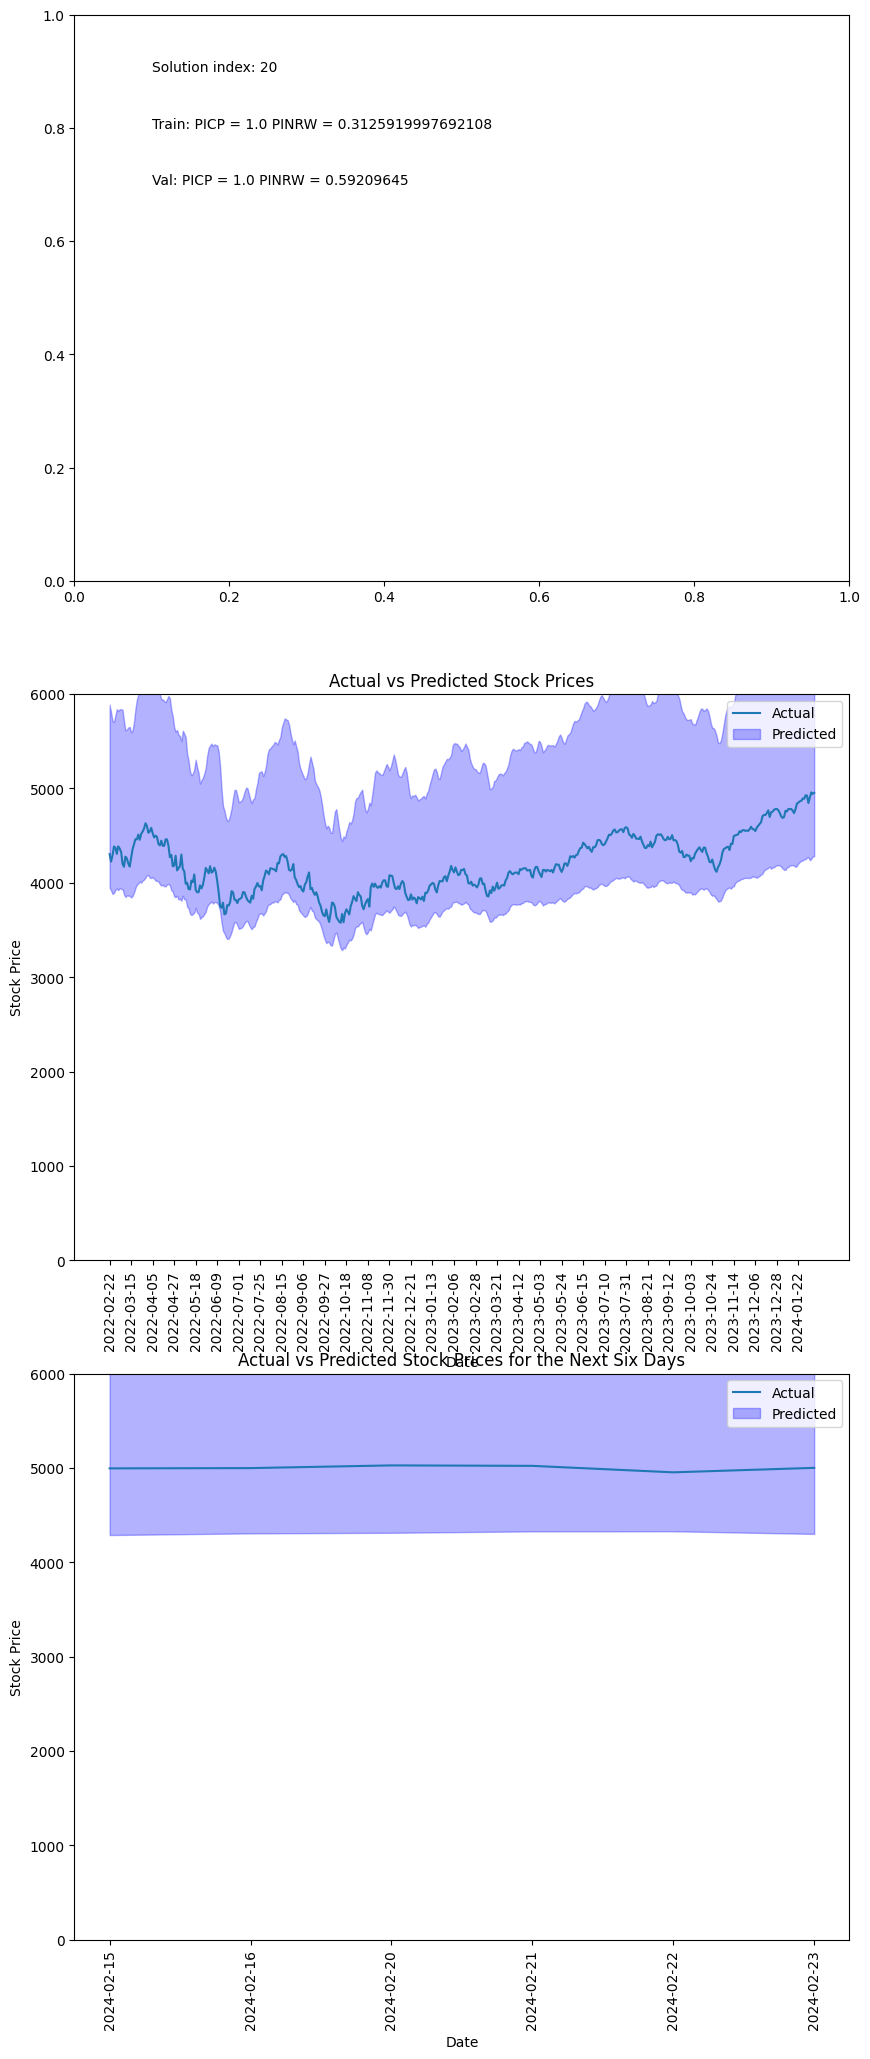

/tmp/ipykernel_610501/2836881319.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


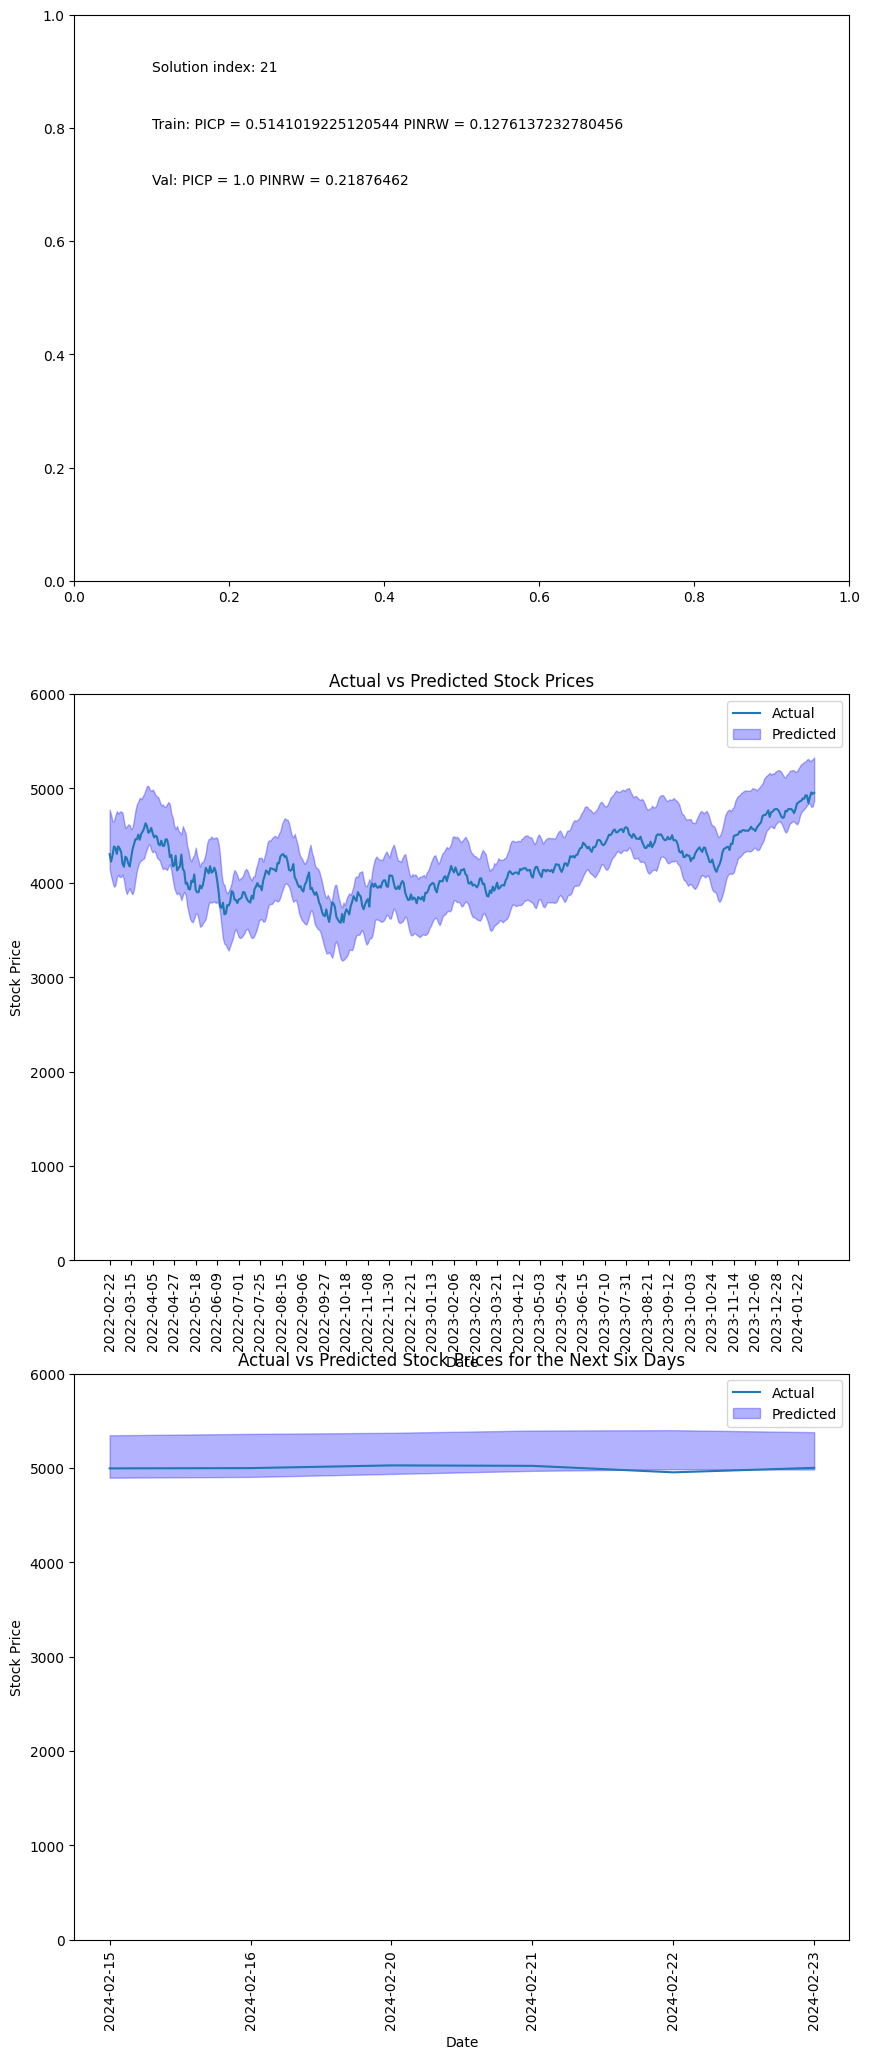

In [39]:
from matplotlib.backends.backend_pdf import PdfPages

X_val = X_test[:-6]
y_val = y_test[:-6]

X_future = X_test[-6:]
last_dates = df['Date'].tail(6)
y_future = y_test_unscaled[-6:]

test_dates_datetime = pd.to_datetime(test_dates)
last_dates_datetime = pd.to_datetime(last_dates)
# Затем используйте strftime() для форматирования даты без времени
test_dates = [date.strftime('%Y-%m-%d') for date in test_dates_datetime]
last_dates = [date.strftime('%Y-%m-%d') for date in last_dates_datetime]



y_val.shape

test.head()

PICP_val = []
PINRW_val = []

with PdfPages('s&p_report_lstm_6_days_ahead.pdf') as pdf:
    for sol_ind in range(len(X)):
        model.set_weights(set_shape(X[sol_ind],shape))
        y_pred = model.predict(X_val, verbose = False)
        PICP_t = PICP(y_val, y_pred).numpy()
        PINRW_t = PINRW(y_pred).numpy()

        PICP_val.append(PICP_t)
        PINRW_val.append(PINRW_t)
        
        
        if PICP_t > 0.98:

            y_pred = scaler.inverse_transform(y_pred)

            fig, axs = plt.subplots(3, 1, figsize=(10, 25))


            # Add text to the plot
            axs[0].text(0.1, 0.9, 'Solution index: ' + str(sol_ind))
            axs[0].text(0.1, 0.8, 'Train: PICP = ' + str(1 - F[sol_ind, 0]) + ' PINRW = ' + str(F[sol_ind, 1]))
            axs[0].text(0.1, 0.7, 'Val: PICP = ' + str(PICP_t) + ' PINRW = ' + str(PINRW_t))


            #построить прогнозирование по тестовой выборке

            
            # Определите, сколько меток вы хотите отобразить
            N = 15
            
            # Получите индексы для меток, выбирая каждую N-ую дату
            indices = range(0, len(test_dates[:-6]), N)

            # Получите значения дат для отображения на оси X
            xticks = [test_dates[:-6][i] for i in indices]
            
            # Отобразить фактические значения
            axs[1].plot(test_dates[:-6], y_test_unscaled[:-6], label='Actual')
            
            # Отобразить предсказания по тестовой выборке с заполнением между lower bound и upper bound
            axs[1].fill_between(test_dates[:-6], y_pred[:, 0], y_pred[:, 1], color='blue', alpha=0.3, label='Predicted')
            
            axs[1].set_xlabel('Date')
            axs[1].set_ylabel('Stock Price')
            axs[1].set_title('Actual vs Predicted Stock Prices')
            axs[1].set_ylim(0, 6000)

            axs[1].set_xticks(indices)
        

            # Установить поворот меток по оси X
            axs[1].set_xticklabels(xticks, rotation=90)
            axs[1].legend()
            
            # Установить поворот меток оси X в главных метках
            plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

            
            
            # Predict and plot the future six days
            
            # Прогноз на 6 дней вперед
            y_pred_future = model.predict(X_future, verbose=False)
            y_pred_future = scaler.inverse_transform(y_pred_future)
            
    
            # Отобразить фактические значения
            axs[2].plot(last_dates, y_future, label='Actual')
            
            # Отобразить предсказания на 6 дней вперед с заполнением между lower bound и upper bound
            axs[2].fill_between(last_dates, y_pred_future[:, 0], y_pred_future[:, 1], color='blue', alpha=0.3, label='Predicted')
            
            axs[2].set_xlabel('Date')
            axs[2].set_ylabel('Stock Price')
            axs[2].set_title('Actual vs Predicted Stock Prices for the Next Six Days')
            axs[2].set_ylim(0, 6000)
            

            # Установить поворот меток по оси X
            axs[2].set_xticklabels(last_dates, rotation=90)
            axs[2].legend()
            
            # Установить поворот меток оси X в главных метках
            plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

            # Save the figure to a PDF
            pdf.savefig(fig) 

            plt.show()

Используем лучшую модель как начальное приближение для нового поиска

In [48]:
from pymoo.core.population import Population

# Число случайных векторов, которые нужно созддать
num_additional_vectors = model.count_params() + 2  # Ваше выражение для определения количества случайных векторов

# Создание случайных векторов вокруг вектора X
additional_vectors = []
for _ in range(num_additional_vectors):
    # Генерация случайного шума с нулевым средним и небольшой дисперсией
    noise = np.random.normal(loc=0, scale=0.1, size=X[21].shape)
    # Добавление шума к вектору X
    additional_vector = X[21] + noise
    additional_vectors.append(additional_vector)

# начальное приближение для популяции
initial_guess = np.vstack([X[21]] + additional_vectors)

algorithm2 = NSGA2(
    pop_size = num_additional_vectors,
    n_offsprings=2,
    sampling=Population.new("X", initial_guess),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)


In [49]:
termination2 = get_termination("n_gen", 50)

res = minimize(problem,
               algorithm2,
               termination2,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

64/64 [==============================] - 0s 3ms/step
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      505 |     22 |             - |             -
44/64 [===================>..........] - ETA: 0s

/home/alexander/mambaforge/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


64/64 [==============================] - 0s 2ms/step
     2 |      507 |     22 |  0.000000E+00 |             f
64/64 [==============================] - 0s 2ms/step
     3 |      509 |     22 |  0.000000E+00 |             f
64/64 [==============================] - 0s 2ms/step
     4 |      511 |     22 |  0.000000E+00 |             f
64/64 [==============================] - 0s 2ms/step
     5 |      513 |     22 |  0.000000E+00 |             f
64/64 [==============================] - 0s 2ms/step
     6 |      515 |     22 |  0.000000E+00 |             f
64/64 [==============================] - 0s 2ms/step
     7 |      517 |     22 |  0.000000E+00 |             f
64/64 [==============================] - 0s 2ms/step
     8 |      519 |     22 |  0.0034872377 |             f
64/64 [==============================] - 0s 2ms/step
     9 |      521 |     22 |  0.000000E+00 |             f
64/64 [==============================] - 0s 2ms/step
    10 |      523 |     22 |  0.000000E+00 |       

In [59]:
X_df.to_csv(f'LSTM_X_S&P_2nd_search_{current_datetime_str}.csv')

F_df.to_csv(f'LSTM_F_S&P_2nd_search_{current_datetime_str}.csv')

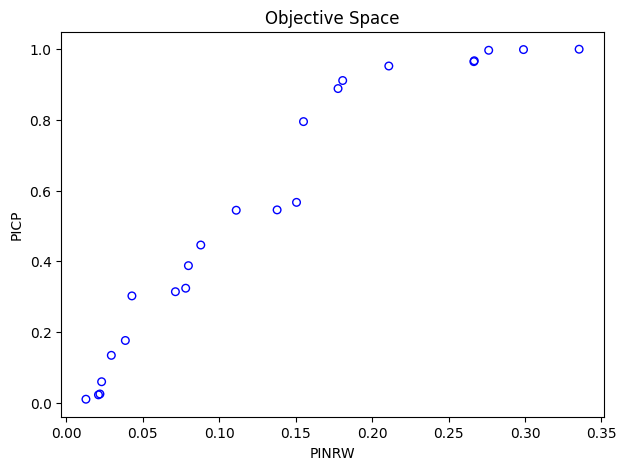

In [53]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], 1 - F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel('PINRW')
plt.ylabel('PICP')
plt.show()

/tmp/ipykernel_610501/1916342282.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


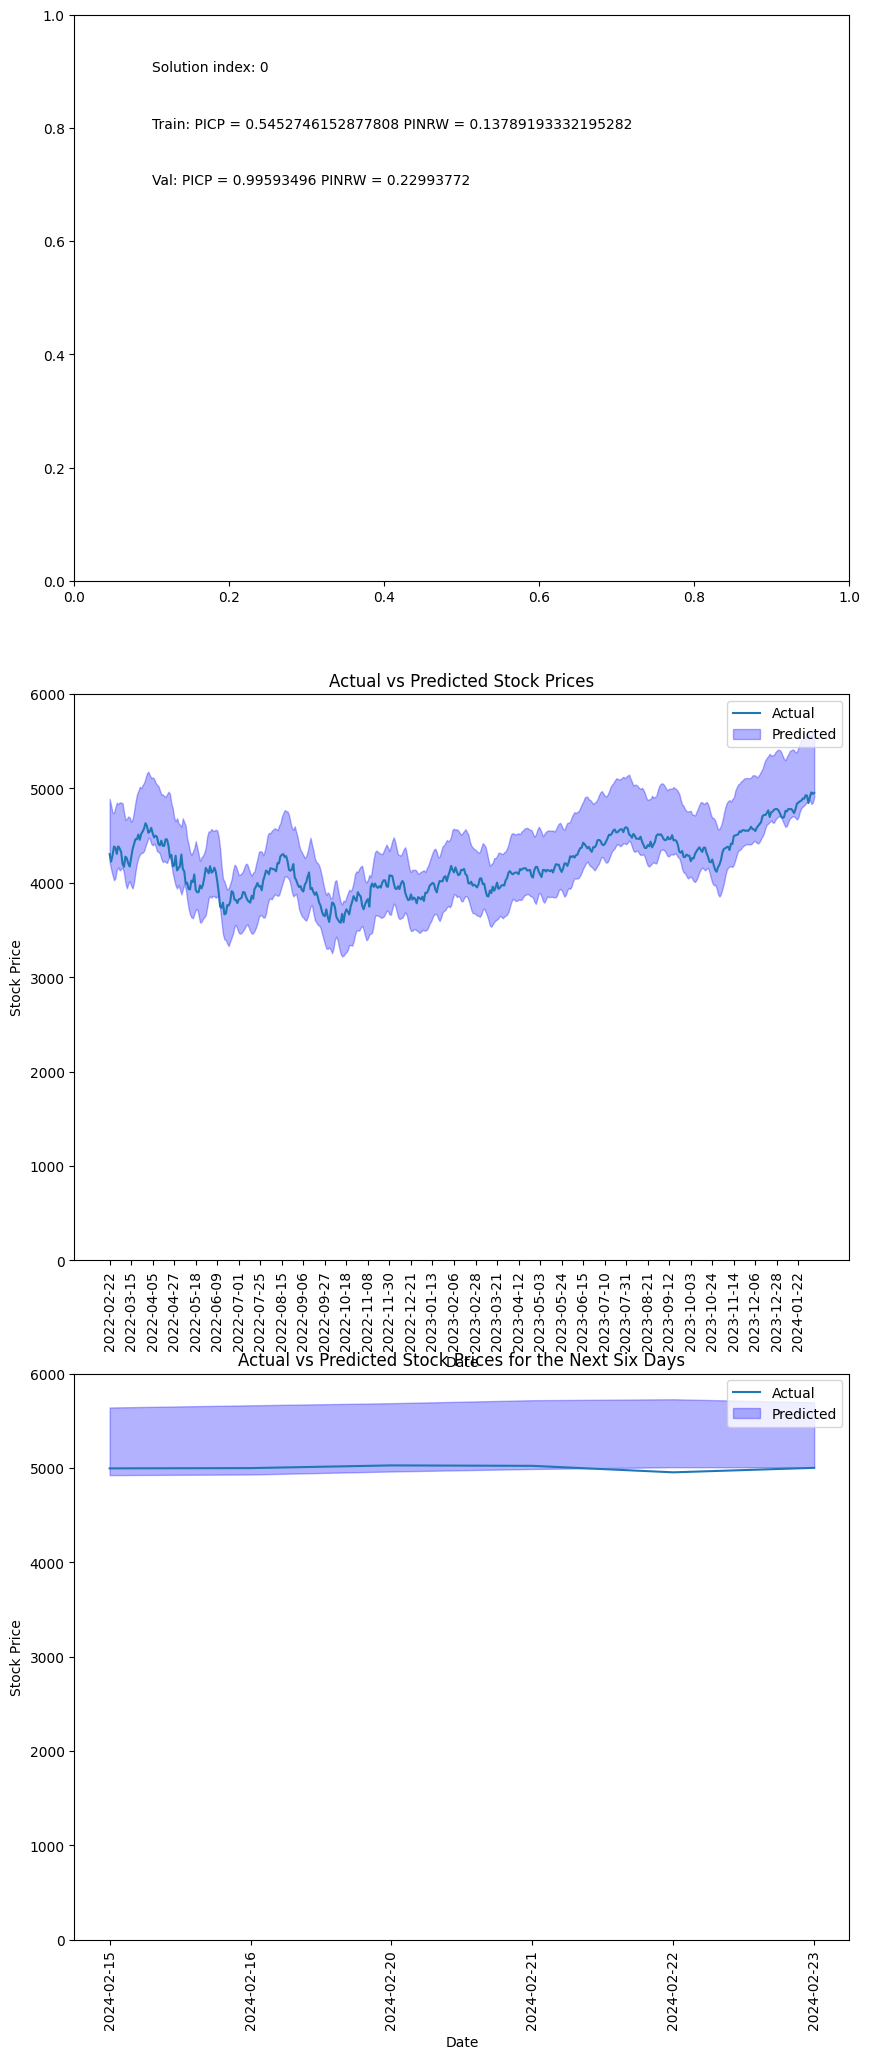

/tmp/ipykernel_610501/1916342282.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


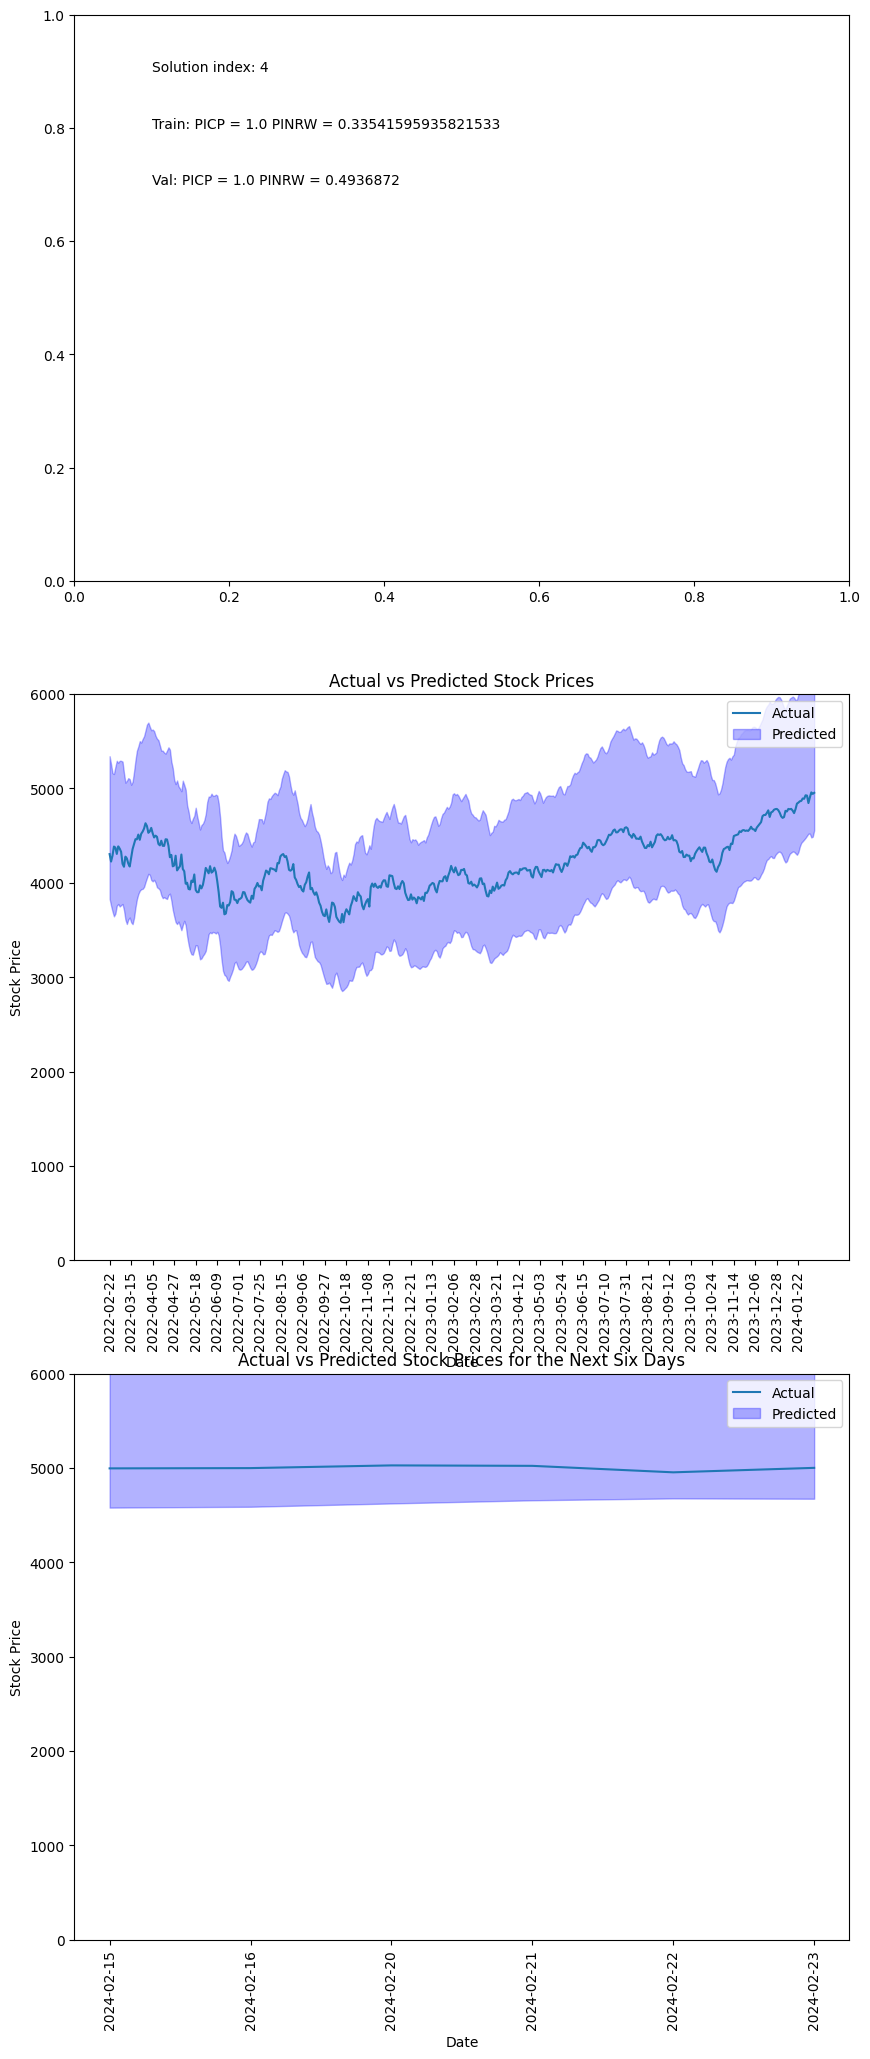

/tmp/ipykernel_610501/1916342282.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


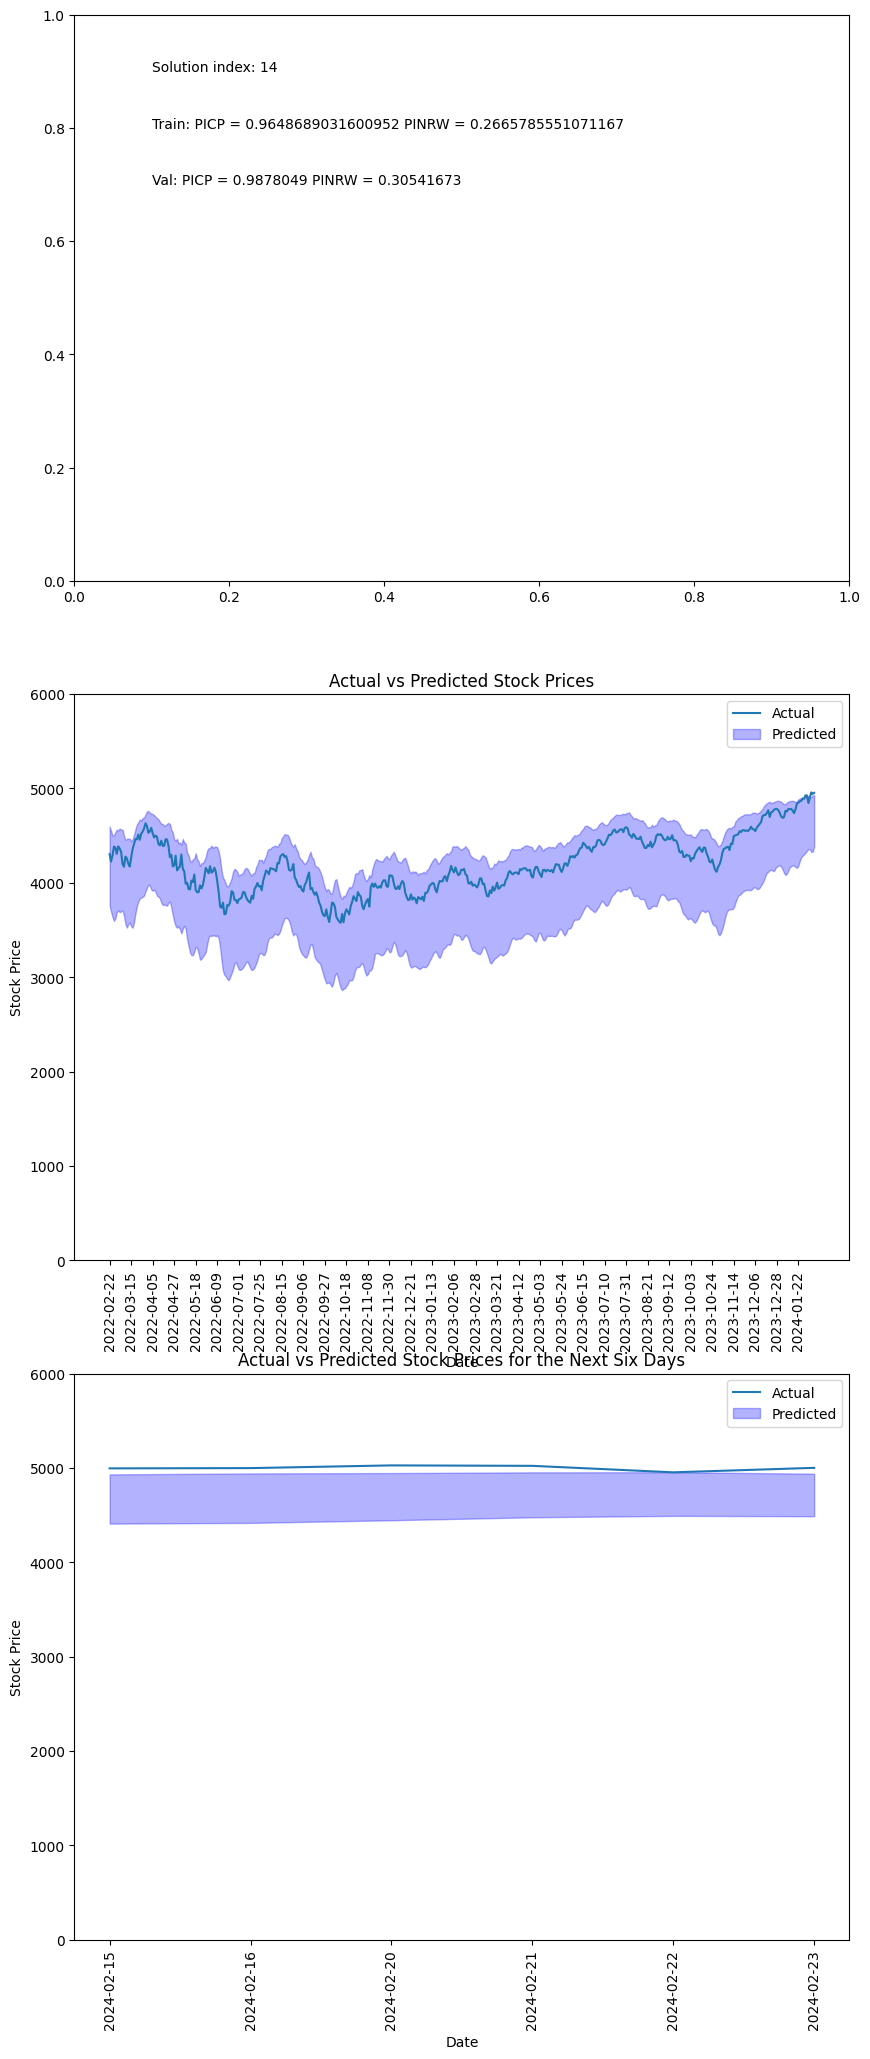

/tmp/ipykernel_610501/1916342282.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


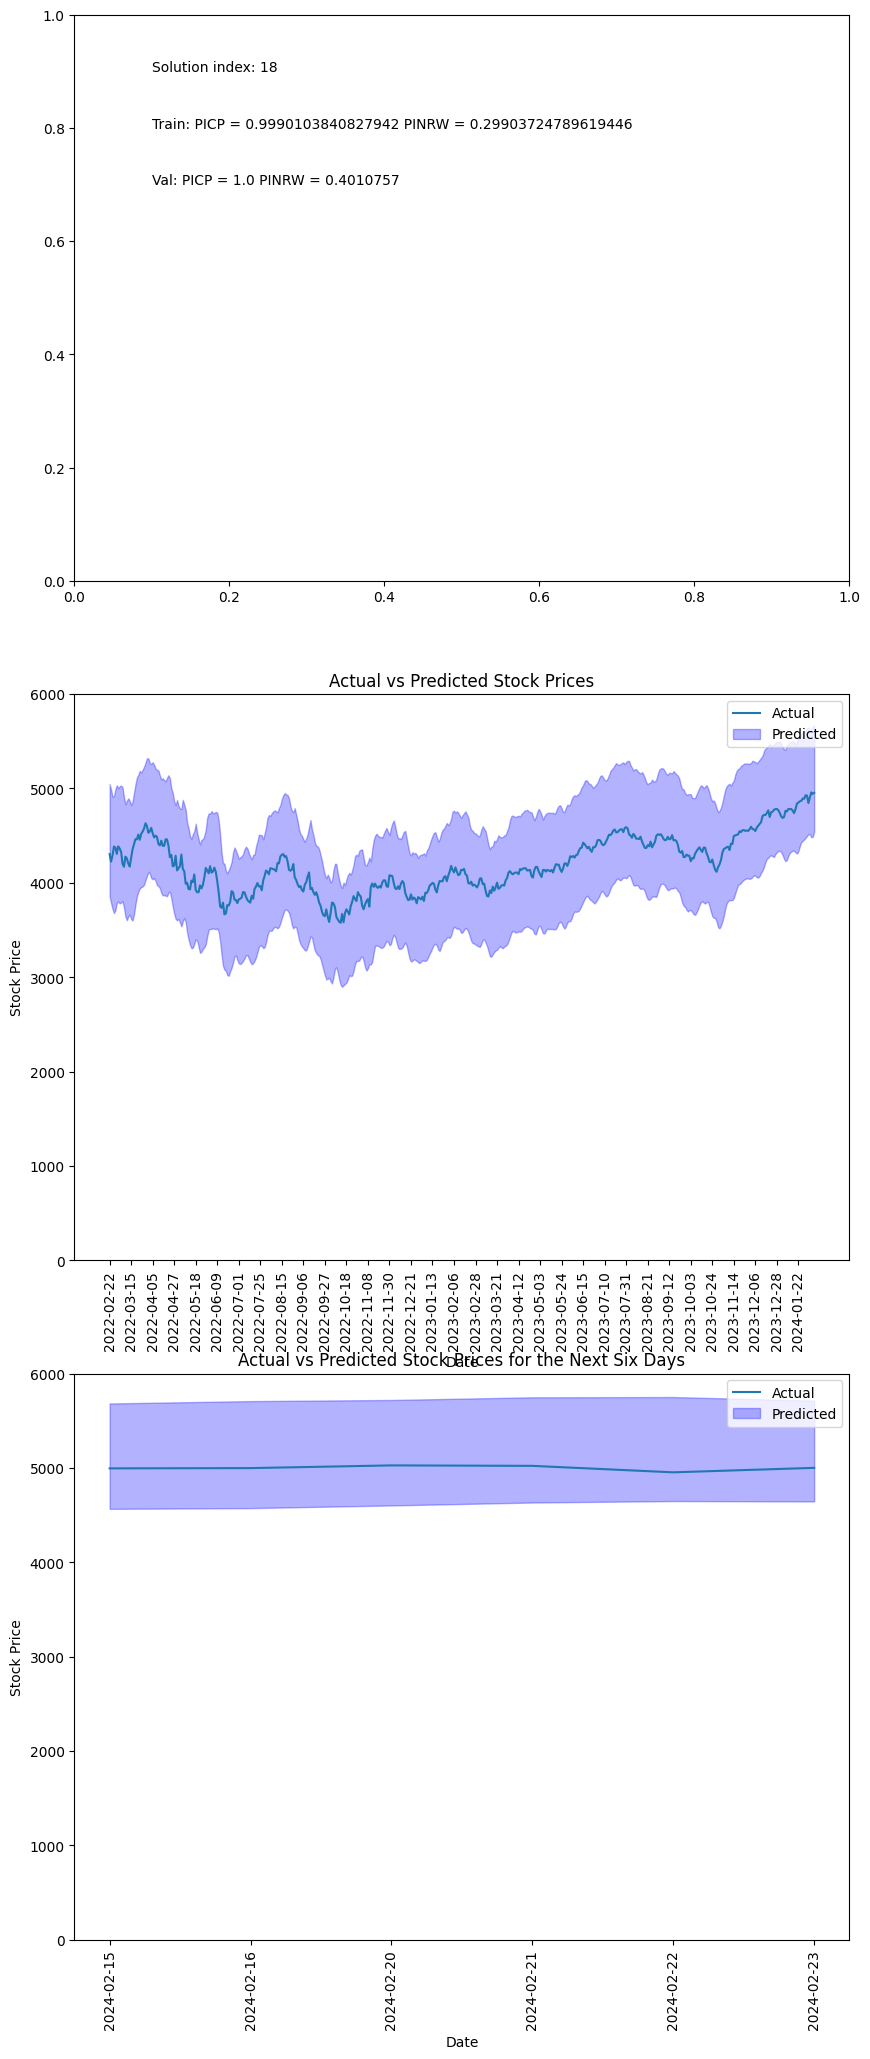

/tmp/ipykernel_610501/1916342282.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


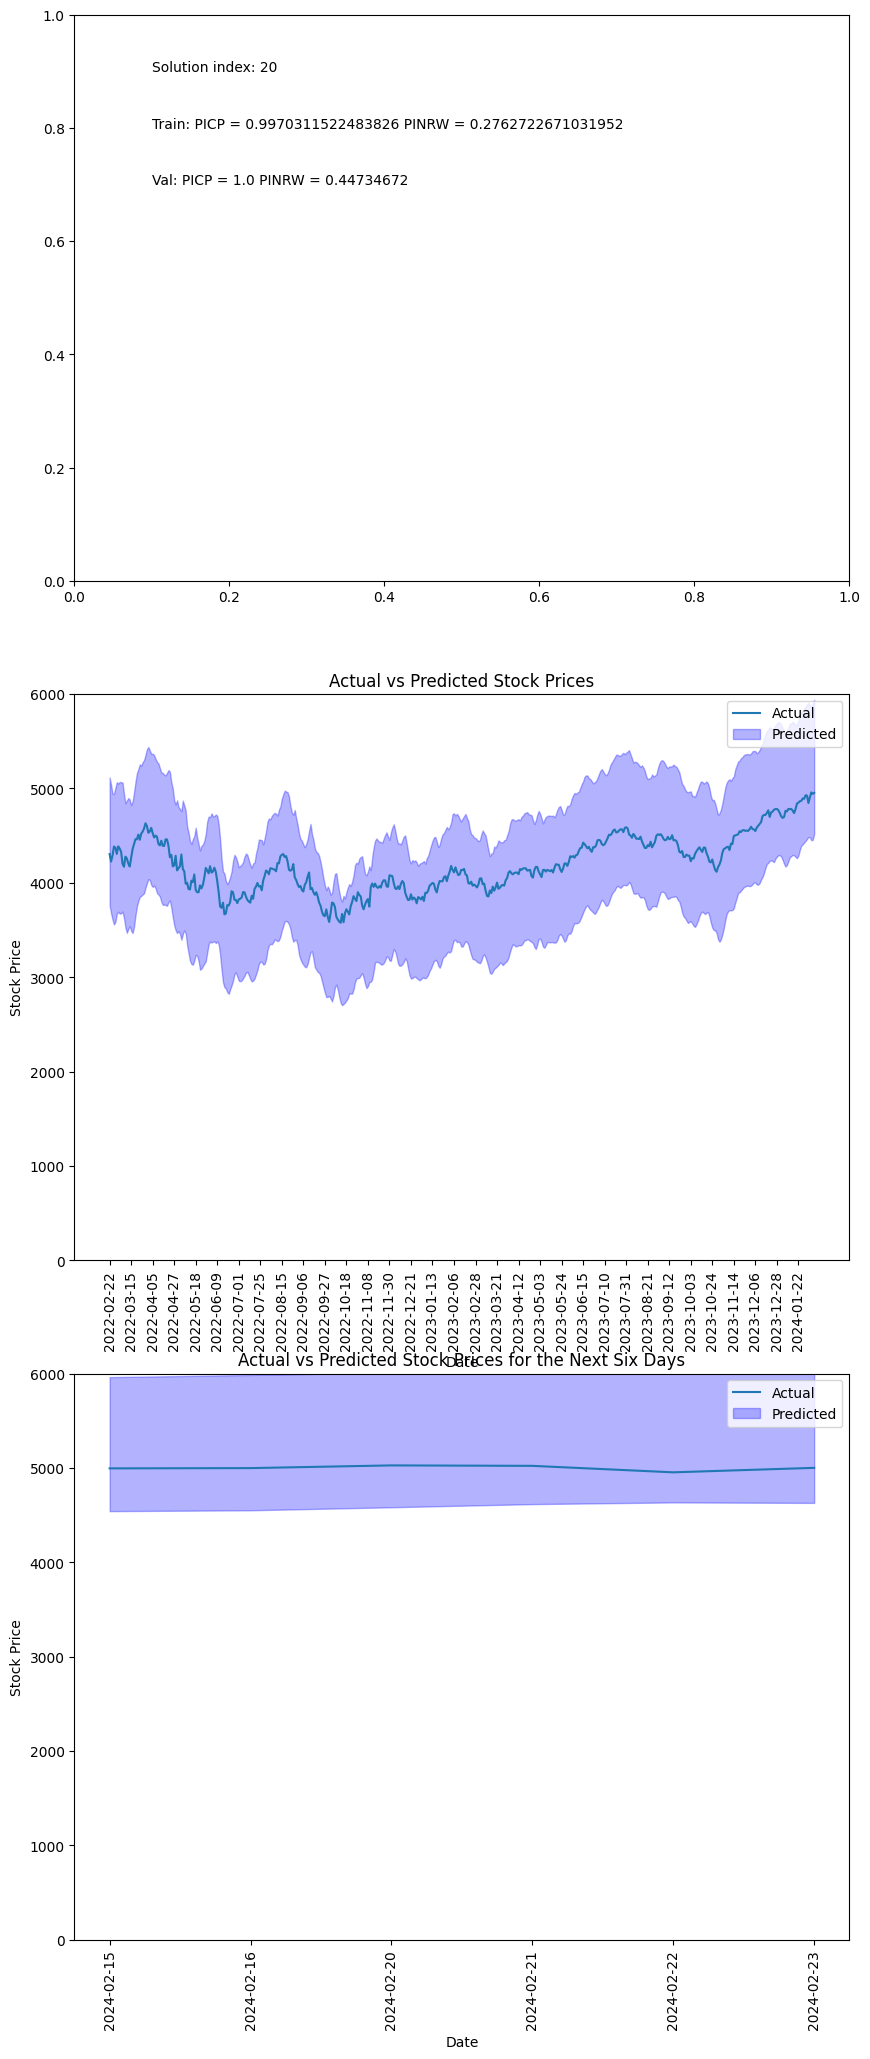

/tmp/ipykernel_610501/1916342282.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


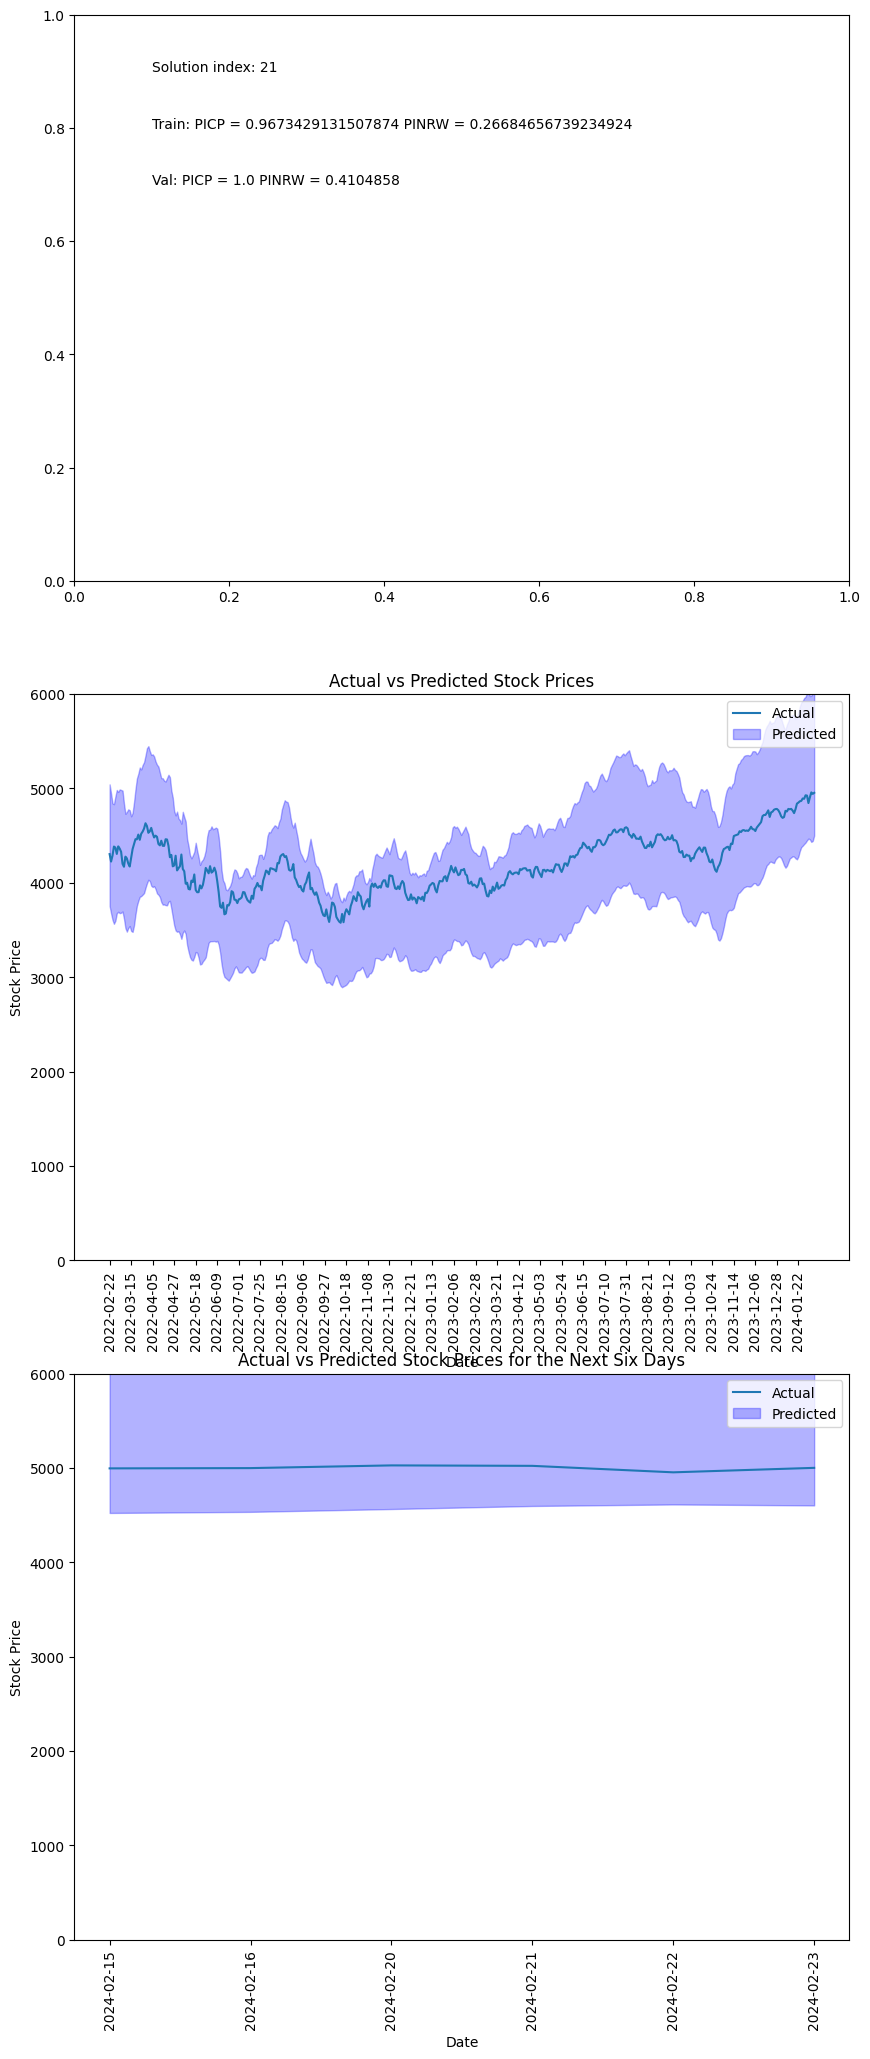

/tmp/ipykernel_610501/1916342282.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(last_dates, rotation=90)


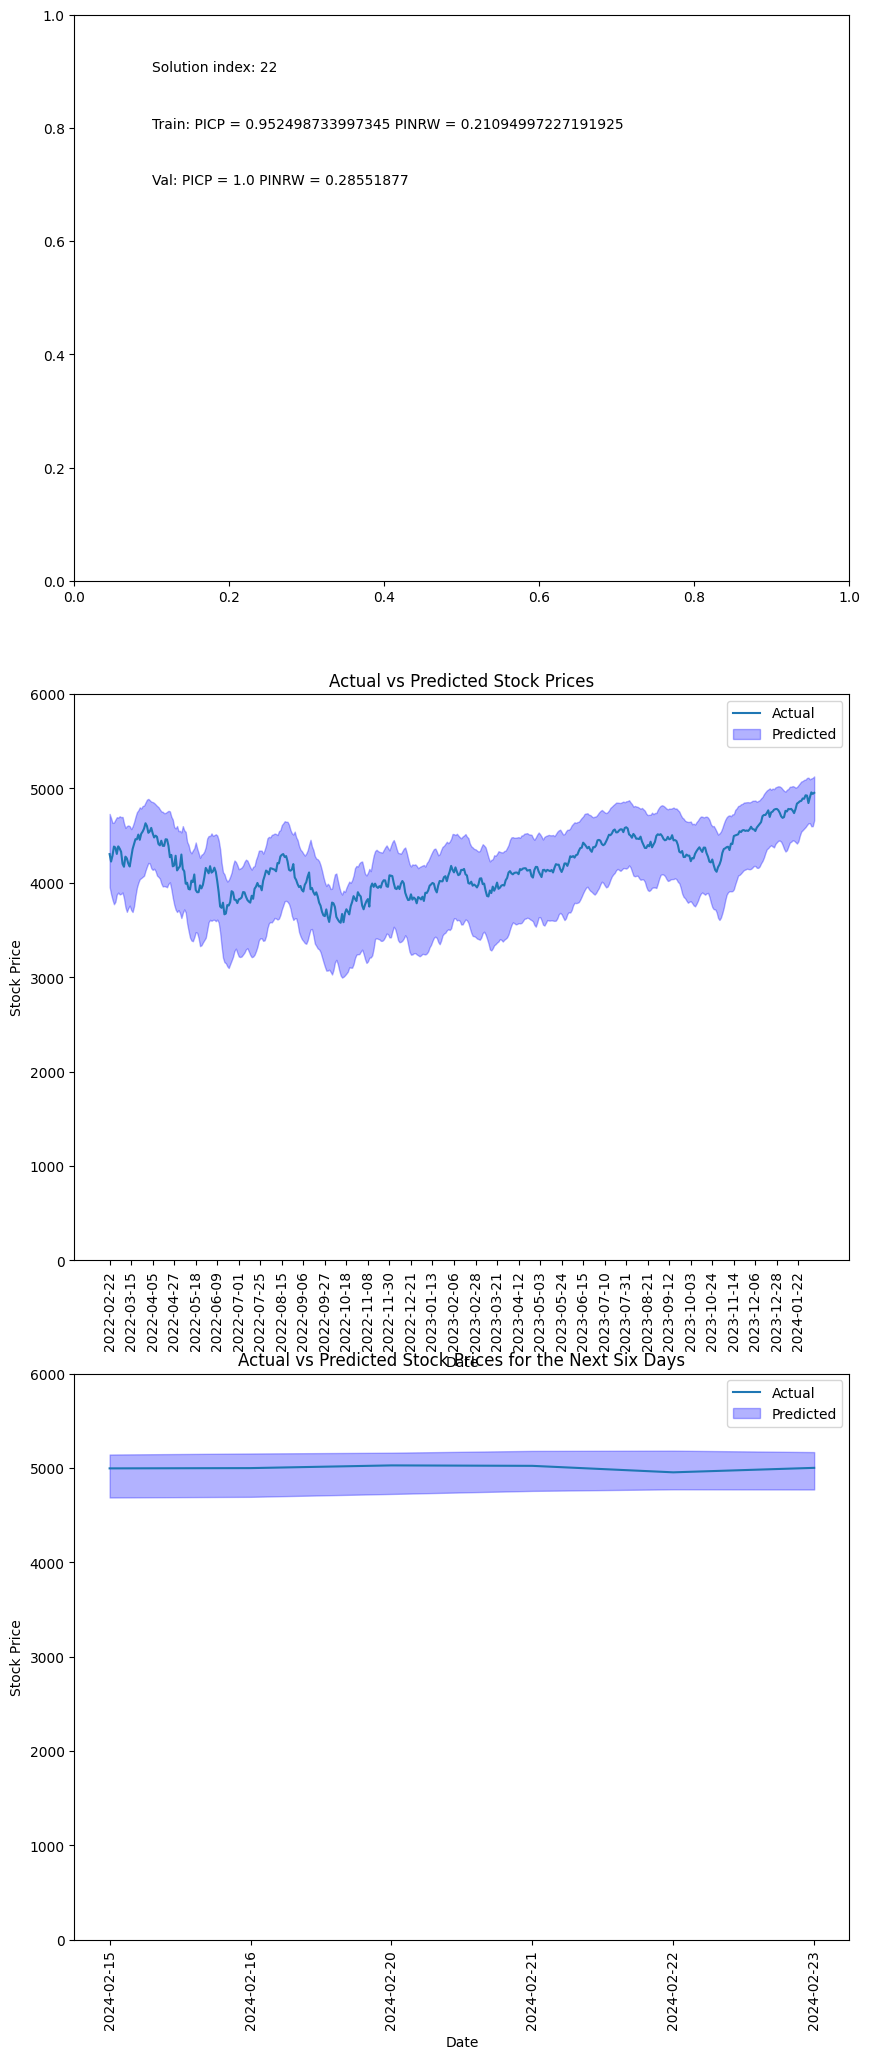

In [51]:
PICP_val = []
PINRW_val = []

with PdfPages('s&p_report_lstm_6_days_ahead_2nd_search.pdf') as pdf:
    for sol_ind in range(len(X)):
        model.set_weights(set_shape(X[sol_ind],shape))
        y_pred = model.predict(X_val, verbose = False)
        PICP_t = PICP(y_val, y_pred).numpy()
        PINRW_t = PINRW(y_pred).numpy()

        PICP_val.append(PICP_t)
        PINRW_val.append(PINRW_t)
        
        
        if PICP_t > 0.98:

            y_pred = scaler.inverse_transform(y_pred)

            fig, axs = plt.subplots(3, 1, figsize=(10, 25))


            # Add text to the plot
            axs[0].text(0.1, 0.9, 'Solution index: ' + str(sol_ind))
            axs[0].text(0.1, 0.8, 'Train: PICP = ' + str(1 - F[sol_ind, 0]) + ' PINRW = ' + str(F[sol_ind, 1]))
            axs[0].text(0.1, 0.7, 'Val: PICP = ' + str(PICP_t) + ' PINRW = ' + str(PINRW_t))


            #построить прогнозирование по тестовой выборке

            
            # Определите, сколько меток вы хотите отобразить
            N = 15
            
            # Получите индексы для меток, выбирая каждую N-ую дату
            indices = range(0, len(test_dates[:-6]), N)

            # Получите значения дат для отображения на оси X
            xticks = [test_dates[:-6][i] for i in indices]
            
            # Отобразить фактические значения
            axs[1].plot(test_dates[:-6], y_test_unscaled[:-6], label='Actual')
            
            # Отобразить предсказания по тестовой выборке с заполнением между lower bound и upper bound
            axs[1].fill_between(test_dates[:-6], y_pred[:, 0], y_pred[:, 1], color='blue', alpha=0.3, label='Predicted')
            
            axs[1].set_xlabel('Date')
            axs[1].set_ylabel('Stock Price')
            axs[1].set_title('Actual vs Predicted Stock Prices')
            axs[1].set_ylim(0, 6000)

            axs[1].set_xticks(indices)
        

            # Установить поворот меток по оси X
            axs[1].set_xticklabels(xticks, rotation=90)
            axs[1].legend()
            
            # Установить поворот меток оси X в главных метках
            plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

            
            
            # Predict and plot the future six days
            
            # Прогноз на 6 дней вперед
            y_pred_future = model.predict(X_future, verbose=False)
            y_pred_future = scaler.inverse_transform(y_pred_future)
            
    
            # Отобразить фактические значения
            axs[2].plot(last_dates, y_future, label='Actual')
            
            # Отобразить предсказания на 6 дней вперед с заполнением между lower bound и upper bound
            axs[2].fill_between(last_dates, y_pred_future[:, 0], y_pred_future[:, 1], color='blue', alpha=0.3, label='Predicted')
            
            axs[2].set_xlabel('Date')
            axs[2].set_ylabel('Stock Price')
            axs[2].set_title('Actual vs Predicted Stock Prices for the Next Six Days')
            axs[2].set_ylim(0, 6000)
            

            # Установить поворот меток по оси X
            axs[2].set_xticklabels(last_dates, rotation=90)
            axs[2].legend()
            
            # Установить поворот меток оси X в главных метках
            plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

            # Save the figure to a PDF
            pdf.savefig(fig) 

            plt.show()